In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [3]:
movil = pd.read_csv('datasets/demanda.csv', dayfirst=True, thousands='.', parse_dates=True, index_col='TIPO')
movil.tail()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2018-04-01,4084110,3131427,3277777,10493315
2018-05-01,4276830,3101854,3286778,10665462
2018-06-01,5569775,3231036,3123287,11924098
2018-07-01,6167114,3326186,3112541,12605842
2018-08-01,5359054,3237765,3112882,11709701


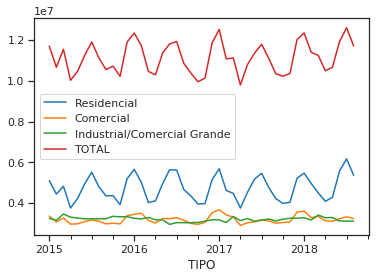

In [4]:
columns = [
    'Residencial',
    'Comercial',
    'Industrial/Comercial Grande',
    'TOTAL',
]
movil[columns].plot()

In [5]:
movil[columns].describe()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
count,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01
mean,4.745018e+06,3.193531e+06,3.201239e+06,1.113979e+07
std,6.270953e+05,1.937162e+05,1.070309e+05,7.643435e+05
min,3.754330e+06,2.900824e+06,2.950818e+06,9.793759e+06
25%,4.222957e+06,3.038991e+06,3.122472e+06,1.046609e+07
50%,4.715576e+06,3.151394e+06,3.215652e+06,1.112625e+07
75%,5.201443e+06,3.312378e+06,3.266523e+06,1.180056e+07
max,6.167114e+06,3.670275e+06,3.460880e+06,1.260584e+07


In [6]:
y = movil['TOTAL'].copy()
y.index = y.index.to_period(freq='M')
ts = movil['TOTAL']

In [7]:
# Descomposition
decomposition = sm.tsa.x13_arima_analysis(ts, x12path='.')

In [8]:
decomposition.seasadj.tail()

TIPO
2018-04-01    1.140990e+07
2018-05-01    1.092209e+07
2018-06-01    1.142037e+07
2018-07-01    1.161864e+07
2018-08-01    1.163825e+07
Name: seasadj, dtype: float64

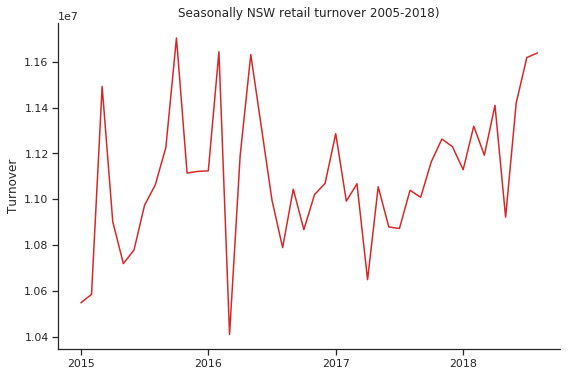

In [9]:
fig, ax= plt.subplots(figsize=(9,6))
decomposition.seasadj.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Turnover')
ax.set_title('Seasonally NSW retail turnover 2005-2018)')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

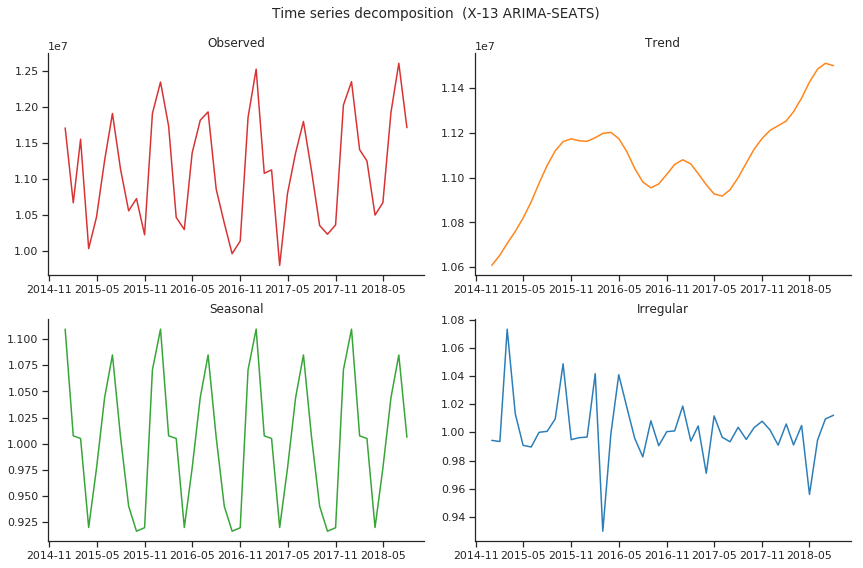

In [10]:
from plotting import plot_components_x13
plot_components_x13(decomposition)
plt.show()

## Trend corrected exponential smoothing

Before we model and forecast the original series, the next cells demonstrate the application of the trend corrected exponential smoothing method, focusing on the seasonally adjusted series for coherence. 

In [11]:
ts=decomposition.seasadj
ts.index=ts.index.to_period(freq='M')

In [12]:
model_sm = sm.tsa.Holt(ts).fit()
smoothed_sm = model_sm.fittedvalues
alpha_sm = model_sm.model.params['smoothing_level']
betha_sm = model_sm.model.params['smoothing_slope']
mse_sm = sm.tools.eval_measures.mse(ts,smoothed_sm)
print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_sm))
print(' Smoothing parameter: betha  {0:.3f}'.format(betha_sm))
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_sm))

 Smoothing parameter: alpha  0.259
 Smoothing parameter: betha  0.000
 In-sample fit:
 MSE               88368760528.262


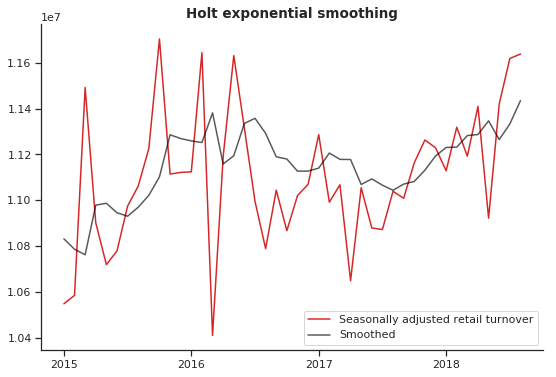

In [13]:
#smoothed=pd.Series(smoothed_sm, index=ts.index)

fig, ax= plt.subplots(figsize=(9,6))

ts['2014':].plot(color='#D62728', label='Seasonally adjusted retail turnover')
smoothed_sm['2014':].plot(color='black', label='Smoothed', alpha=0.65)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

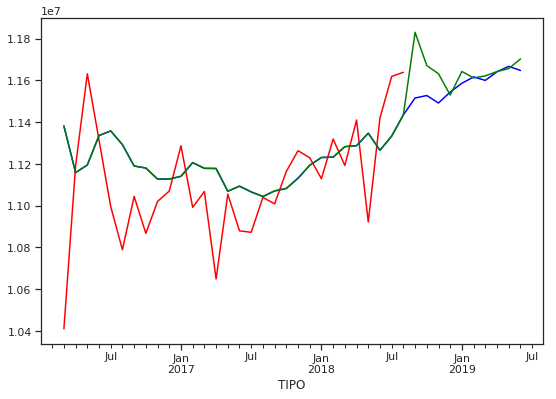

In [14]:
h=10
w=h*3
data = ts
model = sm.tsa.Holt
pred_index = data.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_fit = None
for i in range(0,h):
    current = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current).fit()
    if i==0:
        orig_fit = expanding.fittedvalues
    rolling = model(current.tail(w)).fit()
    pred_expanding.update(expanding.forecast(1))
    pred_rolling.update(rolling.forecast(1))
ax = data[-w:].plot(color='red',figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_fit[-w:],pred_rolling]).plot(ax=ax,color='green');

## Holt-winters exponential smoothing

We estimate several candidate specifications below.  The AIC suggests a multiplicative model without damping for the original series, but we would need to make a likelihood adjustment or a validation set comparison to selected between this method and an additive model for a log transformation. 

In [15]:
def hw_summary(model_sm):
    alpha_sm = model_sm.model.params['smoothing_level']
    betha_sm = model_sm.model.params['smoothing_slope']
    delta_sm = model_sm.model.params['smoothing_seasonal']
    mse_sm = sm.tools.eval_measures.mse(model_sm.data.endog,model_sm.fittedvalues)
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_sm))
    print(' Smoothing parameter: betha  {0:.3f}'.format(betha_sm))
    print(' Smoothing parameter: delta  {0:.3f}'.format(delta_sm))
    print(' In-sample fit:')
    print(' MSE               {0:.3f}'.format(mse_sm))
    print(' RMSE               {0:.3f}'.format(rmse_sm))
    return rmse_sm

In [16]:
ahw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, 
                                   seasonal='add', seasonal_periods=12).fit()

In [17]:
hw_summary(ahw_sm);

 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.421
 In-sample fit:
 MSE               152389189756.988
 RMSE               390370.580


In [18]:
mhw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_sm);

 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.421
 In-sample fit:
 MSE               122865005618.421
 RMSE               350521.049


In [19]:
mhw_damped=sm.tsa.ExponentialSmoothing(y, trend='add', damped=True, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_damped);

 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.421
 In-sample fit:
 MSE               122864609550.387
 RMSE               350520.484


The smoothed series based on the multiplicative method tracks the original series very closely.

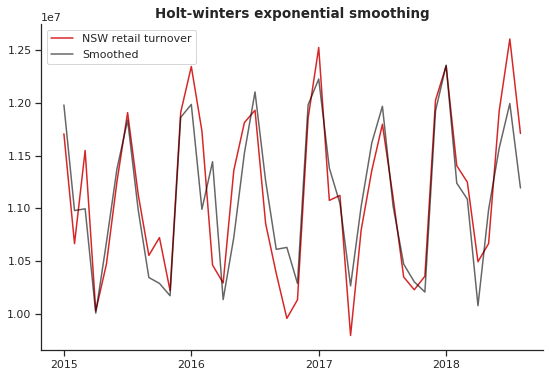

In [20]:
smoothed=pd.Series(mhw_sm.fittedvalues, index=y.index)

fig, ax= plt.subplots(figsize=(9,6))

y['2014':].plot(color='#D62728', label='NSW retail turnover')
smoothed['2014':].plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

## Model diagnostics

We base the diagnostics on the multiplicative Holt-Winters model.  The model seems to adequately capture the time series patterns in the data, leading to small and insignicant residual correlations. The residuals do not follow the normal distribution, so that ideally we should use alternative assumptions for computing prediction intervals. 

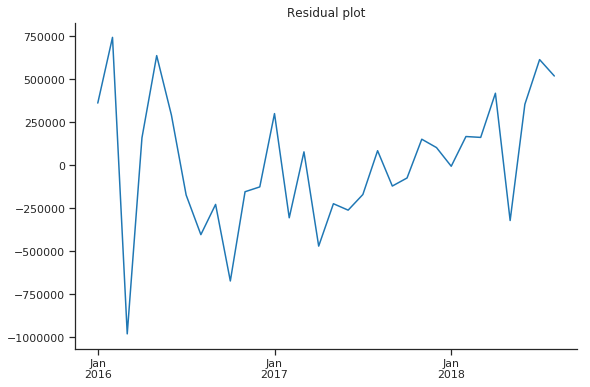

In [21]:
resid = (y-mhw_sm.fittedvalues)[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(9,6))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

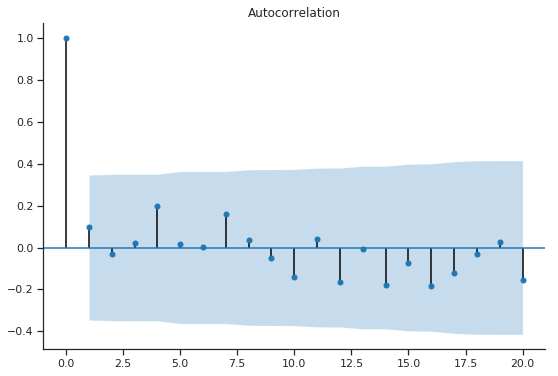

In [22]:
fig, ax = plt.subplots(figsize=(9,6))
sm.graphics.tsa.plot_acf(resid, lags=20, ax=ax)
sns.despine()
plt.show()

/home/emanuel/.virtualenvs/series-temporales/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


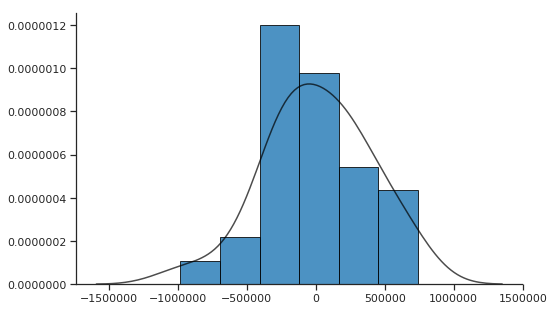

In [23]:
from plotting import histogram

histogram(resid)
plt.show()


## Model validation

The real time forecasting analysis suggests that the log additive Holt Winters model for the log series is the most accurate method for one step ahead forecasts. The Holt-Winters forecasts perform significantly better than a seasonal random walk. 

In [24]:
y

TIPO
2015-01    11706190
2015-02    10665087
2015-03    11548527
2015-04    10026435
2015-05    10467634
2015-06    11254420
2015-07    11907362
2015-08    11130263
2015-09    10552903
2015-10    10722174
2015-11    10219189
2015-12    11909436
2016-01    12344912
2016-02    11731845
2016-03    10461476
2016-04    10292001
2016-05    11358012
2016-06    11812947
2016-07    11929645
2016-08    10855442
2016-09    10382081
2016-10     9956039
2016-11    10132541
2016-12    11853854
2017-01    12524866
2017-02    11074906
2017-03    11122232
2017-04     9793759
2017-05    10795213
2017-06    11359331
2017-07    11796426
2017-08    11107251
2017-09    10348585
2017-10    10227329
2017-11    10355727
2017-12    12024595
2018-01    12350183
2018-02    11404203
2018-03    11247242
2018-04    10493315
2018-05    10665462
2018-06    11924098
2018-07    12605842
2018-08    11709701
Freq: M, Name: TOTAL, dtype: int64

In [25]:
start_val = y.index[-round(len(y)/12*.2)*12]
start_val

Period('2017-09', 'M')

In [26]:
# Real time forecasting 

validation=y[start_val:].index
start = y.index.get_loc(start_val) 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # multiplicative holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    

columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Actual']
results = np.vstack([pred1,pred2,pred3,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [27]:
from scipy import stats

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
    table.iloc[i,1] = (results.iloc[:,i] - results.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
Seasonal RW,423432.289,93548.868
Additive,330531.304,85277.147
Multiplicative,327176.494,83264.279


## Forecast

Finally, we generate a two year forecast based on the selected model. 

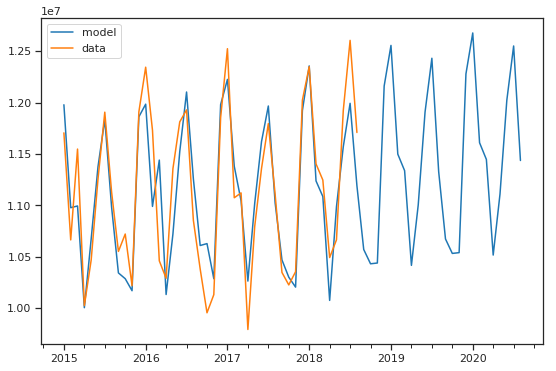

In [28]:
h=24

model = sm.tsa.ExponentialSmoothing(y, 
                    trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()

forecast = model.forecast(h)

plot = pd.DataFrame()
plot['model'] = pd.concat([model.fittedvalues, forecast])
plot['data'] = y
#pd.Series(model.fittedvalues + model.fcastvalues), 
#                         index=pd.period_range(y.index[0],y.index[-1]+h,freq=y.index.freq))

plot['2010':].plot(figsize=(9,6));